# Post-Training: Evaluate Error in Curvature Estimation

# Set up

In [6]:
import os
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "neuralgeom"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/nmiolane/code/neuralgeom/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom/neuralgeom


In [16]:
%load_ext autoreload
%autoreload 2

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import json

import geomstats.backend as gs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Evaluate error with respect to the embedding dimension

In [2]:
ed = [
    2,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
]

curvature_error_ed = [
    0.001689126,
    0.001012303,
    0.002482807,
    0.001903473,
    0.002538689,
    0.002346822,
    0.00185122,
    0.002858928,
    0.001734209,
    0.004227371,
    0.003866927,
    0.0020231,
    0.001000167,
    0.001913845,
    0.002814295,
    0.002451746,
    0.00226067,
    0.003887875,
    0.00125866,
    0.000970031,
    0.001079341,
    0.003844655,
]

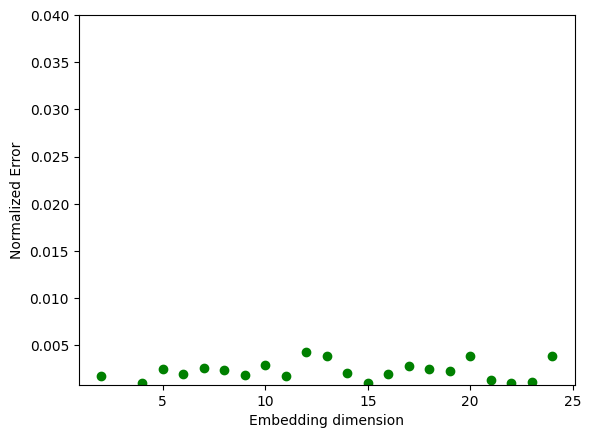

In [3]:
plt.scatter(ed, curvature_error_ed, color="green")
plt.ylim(top=0.04)
plt.xlabel("Embedding dimension")
plt.ylabel("Normalized Error");

## Evaluate error with respect to the noise variance

Text(0, 0.5, 'Normalized Error')

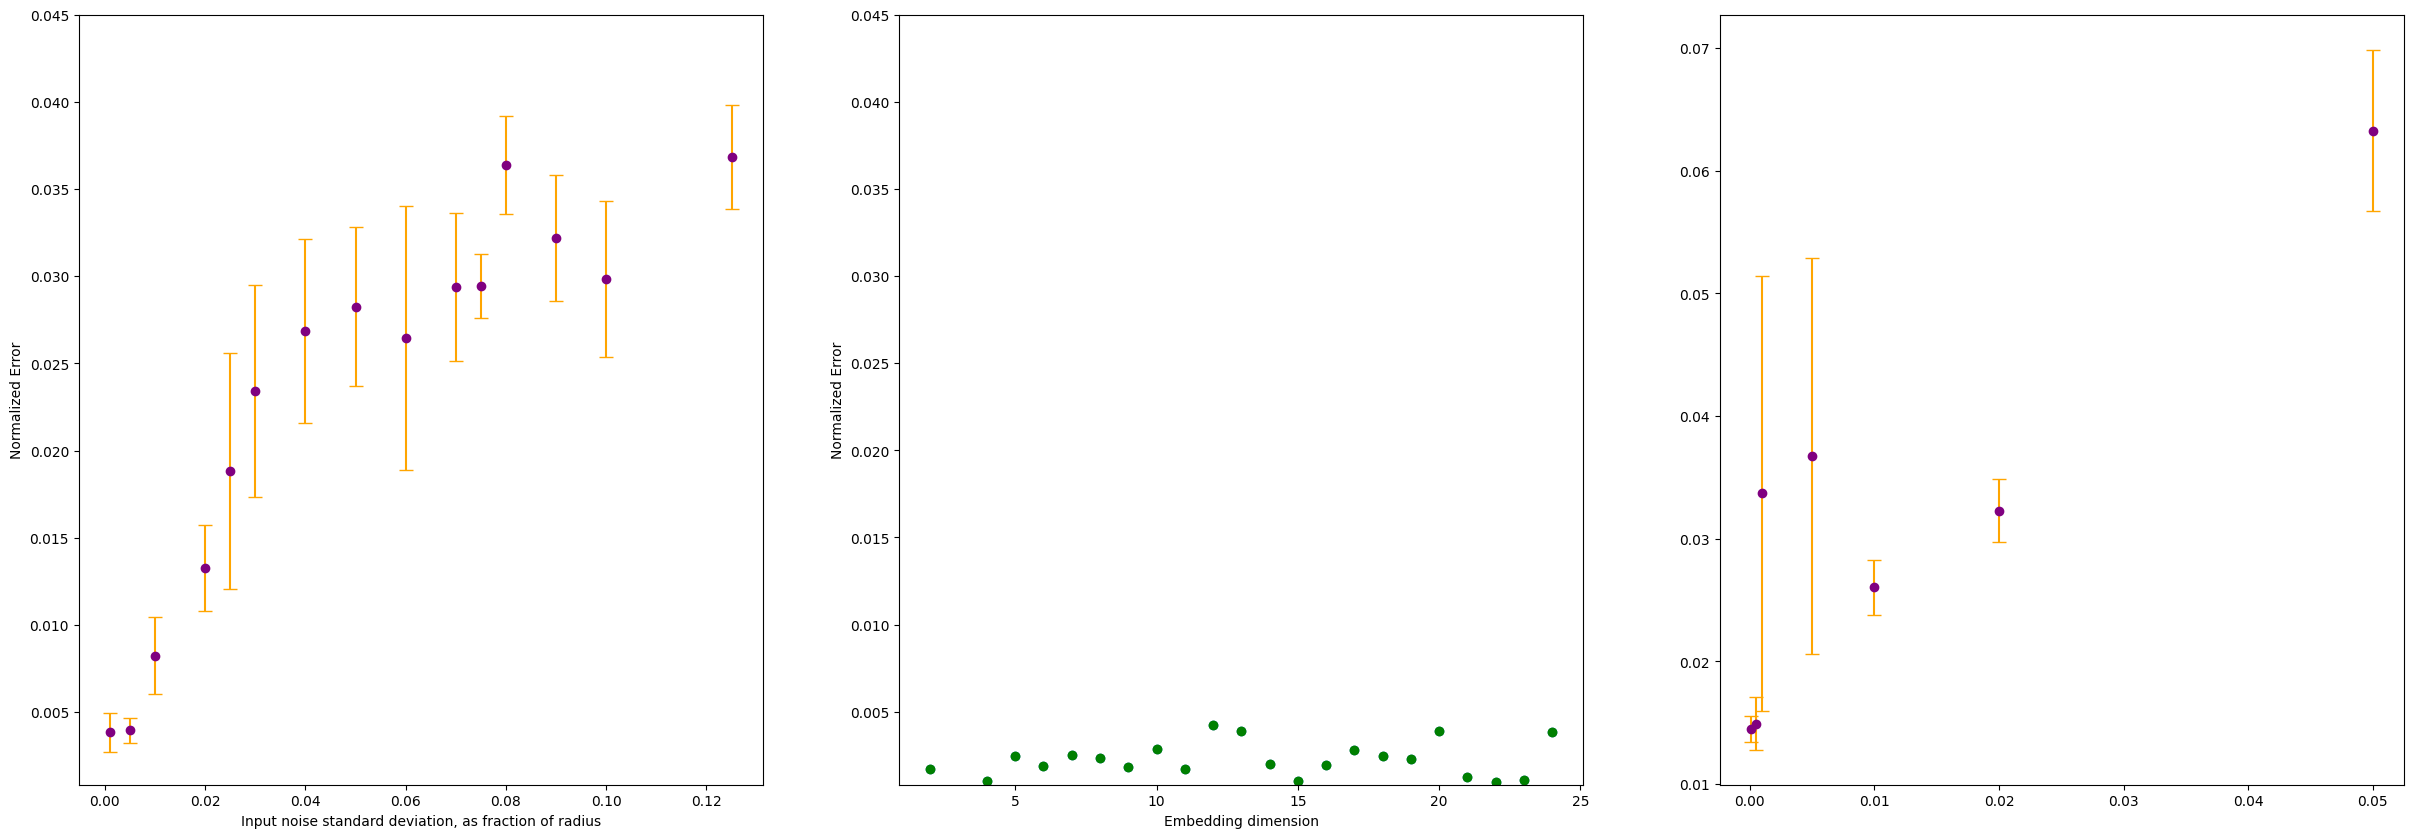

In [4]:
fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(131)

noise_var = [
    0.001,
    0.005,
    0.01,
    0.02,
    0.025,
    0.03,
    0.04,
    0.05,
    0.06,
    0.07,
    0.075,
    0.08,
    0.09,
    0.1,
    0.125,
]


curvature_error_noise = [
    0.0038236,
    0.00393826,
    0.0082392,
    0.013263643,
    0.018831209,
    0.023393472,
    0.026830469,
    0.028257823,
    0.026462683,
    0.029377216,
    0.029433391,
    0.036400927,
    0.032171806,
    0.029818693,
    0.036835936,
]


std = [
    0.00255255,
    0.00162342,
    0.00494583,
    0.005526395,
    0.015162444,
    0.013581833,
    0.011809724,
    0.010161061,
    0.01691731,
    0.009538343,
    0.004111763,
    0.006278068,
    0.00807038,
    0.010022126,
    0.00662975,
]

std = std / np.sqrt(5)

ax.errorbar(
    x=noise_var,
    y=curvature_error_noise,
    yerr=std,
    fmt="o",
    ecolor="orange",
    capsize=5,
    color="purple",
)
plt.xlabel("Input noise standard deviation, as fraction of radius")
plt.ylabel("Normalized Error")
plt.ylim(top=0.045)

# plt.savefig("est_theory.svg")
noise_vars2 = [0.02, 0.05, 0.01, 0.005, 0.0005, 0.001, 0.0001]

curvature_errors_noise2 = [
    0.032287827,
    0.063259569,
    0.026015801,
    0.036729573,
    0.014929154,
    0.033680042,
    0.01449421,
]

stds2 = [
    0.00579972,
    0.014732794,
    0.005003834,
    0.036167766,
    0.004776713,
    0.039667175,
    0.002329629,
] / np.sqrt(5)

axs2 = fig.add_subplot(133)

axs2.errorbar(
    x=noise_vars2,
    y=curvature_errors_noise2,
    yerr=stds2,
    fmt="o",
    color="purple",
    ecolor="orange",
    capsize=5,
)


ax3 = fig.add_subplot(132)

ax3.scatter(ed, curvature_error_ed)

ax3.set_xlabel("Input noise standard deviation, as fraction of radius")
plt.ylabel("Normalized Error")


ax3.scatter(ed, curvature_error_ed, color="green")
plt.ylim(top=0.045)
plt.xlabel("Embedding dimension")
plt.ylabel("Normalized Error")


# plt.savefig("error.svg")

# Get Learned and True Curvature Profiles

In [77]:
CONFIG_DIR = os.path.join(os.getcwd(), "results", "configs")
CURVATURE_PROFILES_DIR = os.path.join(os.getcwd(), "results", "curvature_profiles")


# Convert a dict into an object where attributes are accessed with "."
# This is needed for the utils.load() function
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [82]:
def config_from_run_id(run_id):
    for config_file in os.listdir(CONFIG_DIR):
        if run_id in config_file:
            print(f"Found: {config_file}")
            run_id_config_file = config_file
    with open(os.path.join(CONFIG_DIR, run_id_config_file), "r") as f:
        config_dict = json.load(f)
    config = AttrDict(config_dict)
    return config


def curvature_profiles_from_run_id(run_id):
    for curv_path in os.listdir(CURVATURE_PROFILES_DIR):
        if run_id in curv_path:
            print(f"Found: {curv_path}")
            if "learned" in curv_path:
                learned_profile_path = curv_path
            elif "true" in curv_path:
                true_profile_path = curv_path
    learned_profile = pd.read_csv(
        os.path.join(
            CURVATURE_PROFILES_DIR,
            config.results_prefix + "_curv_norm_learned_profile.csv",
        )
    )
    true_profile = pd.read_csv(
        os.path.join(
            CURVATURE_PROFILES_DIR,
            config.results_prefix + "_curv_norm_true_profile.csv",
        )
    )
    return learned_profile, true_profile

In [83]:
run_id = "37044f7d"
config = config_from_run_id(run_id)
learned_profile, true_profile = curvature_profiles_from_run_id(run_id)

Found: run_37044f7d_s1_synthetic_noise_var_0.01_embedding_dim_3.json
Found: run_37044f7d_s1_synthetic_noise_var_0.01_embedding_dim_3_curv_norm_learned_profile.csv
Found: run_37044f7d_s1_synthetic_noise_var_0.01_embedding_dim_3_curv_norm_true_profile.csv


In [84]:
learned_profile.head()

,Unnamed: 0,geodesic_dist,curv_norm_learned,z_grid
0,0,0.0,1.580615e+03,0.000000
1,1,0.0,5.208158e+03,0.063467
2,2,0.0,2.268697e+04,0.126933
3,3,0.0,1.336297e+05,0.190400
4,4,0.0,1.035444e+06,0.253866


In [85]:
true_profile.head()

,Unnamed: 0,geodesic_dist,curv_norm_true,z_grid
0,0,0.0,0.999583,0.000000
1,1,0.0,0.998983,0.063467
2,2,0.0,0.997629,0.126933
3,3,0.0,0.994712,0.190400
4,4,0.0,0.988729,0.253866


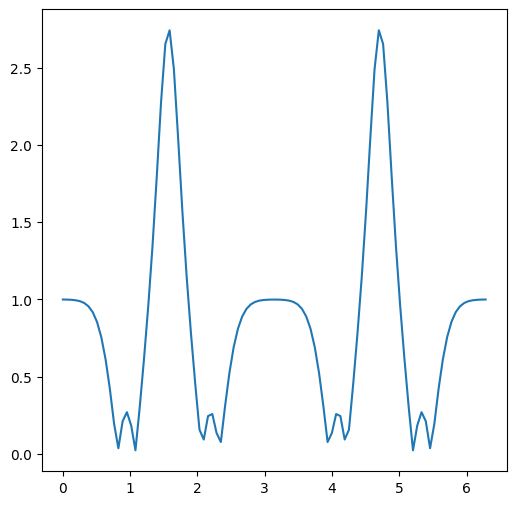

In [60]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

# axes.plot(learned_profile["z_grid"].values, learned_profile["curv_norm_learned"].values)
axes.plot(true_profile["z_grid"].values, true_profile["curv_norm_true"].values);

# Use wandb API to get most recent runs

In [247]:
import pandas as pd
import wandb

api = wandb.Api()
runs = api.runs("bioshape-lab/neuralgeom")
today = pd.to_datetime("2023-03-09")

df_list = []
for i_run, run in enumerate(runs):
    if pd.to_datetime(run.createdAt) > today:
        run_dict = {}
        run_dict.update(run.summary._json_dict)
        config_dict = {
            k: v
            for k, v in run.config.items()
            if (k != "wandb" and not k.startswith("_"))
        }
        run_dict.update(config_dict)
        df_list.append(pd.DataFrame(run_dict, index=[i_run]))
runs_df = pd.concat(df_list)

In [248]:
by_to_color = {"noise_var": "orange", "embedding_dim": "darkgreen"}

In [292]:
def plot_errorbar_by(
    df,
    dataset_name="s1_synthetic",
    by="noise_var",
    select="embedding_dim",
    select_value=2,
):
    df = df[
        [
            "embedding_dim",
            "noise_var",
            "curvature_error",
            "test_loss",
            "test_recon_loss",
        ]
    ][df["dataset_name"] == dataset_name]
    df = df[df[select] == select_value]
    # print("pre-dropna:", np.unique(df[by]))
    df = df.dropna()
    # print("post-dropna:", np.unique(df[by]))
    grouped = df.groupby(by)
    lowest_losses = grouped.apply(lambda x: x.nsmallest(5, "test_recon_loss"))
    df = lowest_losses.reset_index(drop=True)

    mean_dict = {}
    std_dict = {}

    unique_by = np.unique(df[by])
    for by_val in unique_by:
        mean_dict[by_val] = np.mean(df["curvature_error"][df[by] == by_val])
        std_dict[by_val] = np.std(df["curvature_error"][df[by] == by_val])
    plt.scatter(df[by], df["curvature_error"], c="purple", alpha=0.2)
    plt.errorbar(
        [k for k in mean_dict.keys()],
        [v for v in mean_dict.values()],
        [v for v in std_dict.values()],
        fmt="o",
        ecolor=by_to_color[by],
        capsize=5,
        color="purple",
    )
    plt.xlabel(by)
    plt.ylabel("curvature_error")
    plt.title(f"{dataset_name}\n selected: {select} = {select_value}")
    return

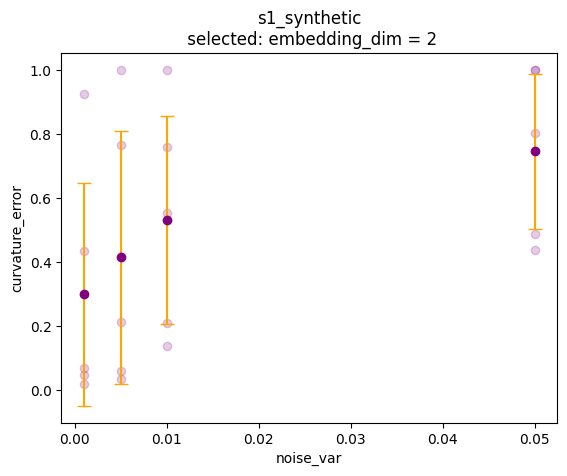

In [294]:
plot_errorbar_by(
    runs_df,
    dataset_name="s1_synthetic",
    by="noise_var",
    select="embedding_dim",
    select_value=2,
)

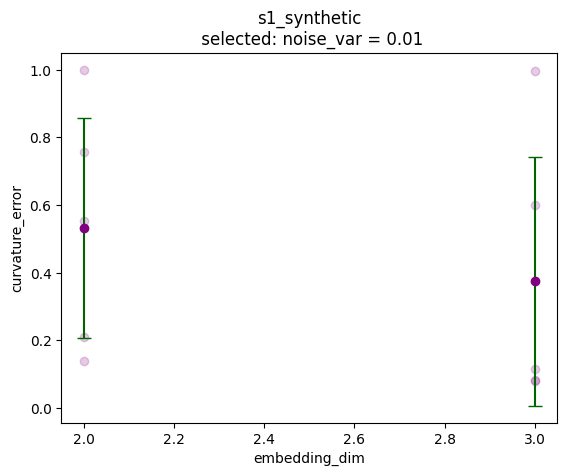

In [295]:
plot_errorbar_by(
    runs_df,
    dataset_name="s1_synthetic",
    by="embedding_dim",
    select="noise_var",
    select_value=0.01,
)